<a href="https://colab.research.google.com/github/omanofx/entregable_1/blob/Proyecto_final_Omar_Fernandez/Copia_de_Primera_Entrega_Omar_Fernandez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import pytz
import requests
import seaborn as sns
#import squarify
import statsmodels.api as sm
import xgboost as xgb

# memory management
import gc

import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_decision_regions

from requests.exceptions import HTTPError

from sklearn import neighbors, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import matplotlib.cm as cm

### Configuración

Configuraciones que se utilizan durante el proyecto en forma general.

In [3]:
# Configura la zona horaria para Argentina
argentina_tz = pytz.timezone('America/Argentina/Buenos_Aires')
formato_fecha_hora = '%Y-%m-%d %H:%M:%S'

# Obtiene la hora actual en UTC
utc_now = datetime.utcnow()

# Convierte la hora actual a la hora local en Argentina
local_time = utc_now.replace(tzinfo=pytz.utc).astimezone(argentina_tz)
print(local_time.strftime('%Y-%m-%d %H:%M:%S'))

2024-02-08 11:51:44


## funciones

In [4]:
#Diccionario para establecer el orden de los meses
orden_meses = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

In [5]:
def fecha_hora_argentina():
  '''
  ## La función se utiliza para mostrar la hora de Argentina cada vez que sea invocada.
  ## Obtiene la hora de Argentina actual en UTC
  '''

  utc_now = datetime.utcnow()
  # Convierte la hora actual a la hora local en Argentina
  local_time = utc_now.replace(tzinfo=pytz.utc).astimezone(argentina_tz)

  return local_time.strftime(formato_fecha_hora)

In [6]:
def tiene_espacios_en_blanco(columna: str):
    return any(x.isspace() for x in columna)

In [7]:
# Definir la función analizar_dataframe
def analizar_dataframe(df1: pd.DataFrame, porcentaje_tolerancia: float):
    '''
    ## Esta función se utiliza para comprobar la consistencia de los datos de un DataFrame
    ### evita invocar a .info(), .isnull()
    #### Porcentaje de tolerancia: valor porcentual que se tolera para los valores nulos de
    #### cada caracteristica del dataset. Si el valor se encuentra por sobre la tolerancia,
    #### se indica como 'BORRAR' la caracteristica.
    '''
    # Validar que porcentaje_tolerancia esté entre 0 y 100
    if not (0 <= porcentaje_tolerancia <= 100):
        print("Error: El porcentaje de tolerancia debe estar entre 0 y 100.")
        return

    porcentaje_perdidos = df1.isnull().sum() * 100 / len(df1)
    total_nulos = df1.isnull().sum()
    tipo_dato = df1.dtypes
    valores_no_nulos_por_columna = df1.count()
    descripcion = df1.describe().transpose()

    resultado_analisis = pd.DataFrame({
        'Tipo de dato': tipo_dato,
        'Total No nulos': valores_no_nulos_por_columna,
        'Total nulos': total_nulos,
        'Porcentaje Nulos': round(porcentaje_perdidos, 2),
        'Borrar': np.where(porcentaje_perdidos > porcentaje_tolerancia, 'BORRAR', ''),
        'Columna con Espacios': df1.columns.to_series().apply(lambda x: tiene_espacios_en_blanco(x))
    })

    # Agregar las columnas de la descripción al resultado_analisis
    resultado_analisis = pd.concat([resultado_analisis, round(descripcion, 2)], axis=1)

    estilo_resultado = (
        resultado_analisis.style
        .applymap(lambda x: 'background-color: red',
                  subset=pd.IndexSlice[resultado_analisis['Porcentaje Nulos'] > porcentaje_tolerancia, 'Porcentaje Nulos'])
        .background_gradient(cmap='Reds', subset=['Porcentaje Nulos'])
        .applymap(lambda x: 'background-color: red' if x else '',
                  subset=pd.IndexSlice[resultado_analisis['Columna con Espacios'], 'Columna con Espacios'])
        .background_gradient(cmap='Reds', subset=['Columna con Espacios'])
    )


    return estilo_resultado

In [8]:
def principales_datos_dataset():
  '''
  ## Esta función muestra los principales datos del dataset principal
  '''

  total_rows, total_cols = df_reservas.shape

  total_adultos = int(df_reservas['adults'].sum())
  total_bebes = int(df_reservas['babies'].sum())
  total_menores = int(df_reservas['children'].sum())

  count_confirmadas = int(df_reservas[df_reservas['is_canceled'] == 0]['is_canceled'].value_counts())
  count_canceladas = int(df_reservas[df_reservas['is_canceled'] == 1]['is_canceled'].value_counts())
  count_resort = int(df_reservas[df_reservas['hotel'] == 'Resort Hotel']['hotel'].value_counts())
  count_city_hotel = int(total_rows - count_resort)

  promedio_pasajeros = (total_adultos + total_bebes + total_menores) / total_rows

  print('El dataframe original contiene un total de', total_cols, 'características y', total_rows, 'observaciones.''\n')
  print('Los principales datos de interés son:''\n')

  print(f"Total de reservas confirmadas: {count_confirmadas}")
  print(f"Total de reservas canceladas: {count_canceladas}"'\n')

  print(f"Total observaciones del tipo hotel resort: {count_resort}")
  print(f"Total observaciones del tipo hotel de ciudad: {count_city_hotel}"'\n')

  print('Distribución poblacional:''\n')
  print('Total adultos:', total_adultos)
  print('Total bebes:', total_bebes)
  print('Total menores:', total_menores)

  print('\n''El promedio de pasajeros por observación es:', round(promedio_pasajeros, 0))

In [9]:
def grabar_csv(nombre_archivo: str, df: pd.DataFrame):
    '''
    ## Almacenamiento fisico de los datos obtenidos.
    ### Graba en un archivo .csv los datos contenidos en un dataset pasados como variable de entrada.
    '''

    try:
        # Convierte la hora actual a la hora local en Argentina
        fecha_y_hora_actual = fecha_hora_argentina()

        # Especifica la ruta y el nombre del archivo CSV
        ruta_archivo_csv = nombre_archivo + fecha_y_hora_actual + '.csv'

        # Guarda el DataFrame en un archivo CSV
        df.to_csv(ruta_archivo_csv, index=False)
        print("Fecha y hora:", fecha_y_hora_actual)
        print(f"Los datos se han guardado en el archivo CSV: {ruta_archivo_csv}")

    except HTTPError as error:
        # Maneja la excepción específica de HTTPError
        print(f"Error HTTP: {error}")
    except Exception as error:
        # Maneja otras excepciones no especificadas
        print(f"Ocurrió un error: {error}")


Supongamos que tienes dos clases: "Cancelada" (1) y "No Cancelada" (0). La matriz de confusión se compone de cuatro valores:

* Verdaderos Positivos (VP): Las reservas que fueron correctamente predichas como canceladas (1).
* Falsos Positivos (FP): Las reservas que fueron incorrectamente predichas como canceladas (1), pero en realidad no fueron canceladas (0).
* Verdaderos Negativos (VN): Las reservas que fueron correctamente predichas como no canceladas (0).
* Falsos Negativos (FN): Las reservas que fueron incorrectamente predichas como no canceladas (0), pero en realidad fueron canceladas (1).

La matriz de confusión se presenta así:

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    # Crear un DataFrame para visualización con seaborn
    labels = ['No Cancelada', 'Cancelada']
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Crear mapa de calor con seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

In [11]:
def graficar_matriz_confusion(df: pd.DataFrame, style: str='Blues', labels=None):
  '''
  ### Grafica la matriz de confusión utilizando la librería Seaborn
  '''
  ax = sns.heatmap(df, annot=True, fmt='d', cmap=style)

  ax.set_title('Matriz de confusión con etiquetas\n\n')
  ax.set_xlabel('Valores predichos')
  ax.set_ylabel('Valores reales')

  if labels is not None:
      ax.xaxis.set_ticklabels(labels)
      ax.yaxis.set_ticklabels(labels)

  plt.show()

In [12]:
def calcular_matriz_correlacion(df_matriz: pd.DataFrame,  metodo: str={'pearson','kendall','spearman'}, tamano_grafico=(20, 20)):
    '''
    Calcula y grafica la matriz de correlación utilizando alguno de los tres métodos: Pearson, Kendall o Spearman.

    Args:
        metodo (str): Método de correlación a utilizar. Puede ser 'pearson', 'kendall' o 'spearman'.
    '''
    # Verifica que el método proporcionado sea uno de los tres permitidos
    #if metodo not in {'pearson', 'kendall', 'spearman'}:
    #  raise ValueError("El método debe ser 'pearson', 'kendall' o 'spearman'.")

    df = df_matriz

    # Calcula la matriz de correlación según el método proporcionado
    if metodo == 'pearson':
        df = df.corr(method='pearson')
    elif metodo == 'kendall':
        df = df.corr(method='kendall')
    elif metodo == 'spearman':
        df = df.corr(method='spearman')

    # Grafica la matriz de correlación
    f, ax = plt.subplots(figsize=(tamano_grafico))
    sns.heatmap(df, annot=True)
    ax.set_title(f"Matriz de correlación con método {metodo}")

    plt.show()

# cargamos el df ya procesado
con la eliminacion de caracteristicas, modificacion de los NaN y nuevas caracteristicas.

In [13]:
#dataset procesado: última version 7-2-2024
df_reservas = pd.read_csv("https://raw.githubusercontent.com/omanofx/entregable_1/Proyecto_final_Omar_Fernandez/df_reservas_ya_procesado.csv", sep = ",")

In [14]:
df_reservas_backup = df_reservas

In [15]:
analizar_dataframe(df_reservas, porcentaje_tolerancia=0)

,Tipo de dato,Total No nulos,Total nulos,Porcentaje Nulos,Borrar,Columna con Espacios,count,mean,std,min,25%,50%,75%,max
hotel,object,85578,0,0.000000,,False,nan,nan,nan,nan,nan,nan,nan,nan
is_canceled,int64,85578,0,0.000000,,False,85578.000000,0.280000,0.450000,0.000000,0.000000,0.000000,1.000000,1.000000
lead_time,int64,85578,0,0.000000,,False,85578.000000,80.730000,85.930000,0.000000,12.000000,50.000000,126.000000,709.000000
arrival_date_year,int64,85578,0,0.000000,,False,85578.000000,2016.220000,0.680000,2015.000000,2016.000000,2016.000000,2017.000000,2017.000000
arrival_date_month,object,85578,0,0.000000,,False,nan,nan,nan,nan,nan,nan,nan,nan
arrival_date_week_number,int64,85578,0,0.000000,,False,85578.000000,26.800000,13.640000,1.000000,16.000000,27.000000,37.000000,53.000000
arrival_date_day_of_month,int64,85578,0,0.000000,,False,85578.000000,15.820000,8.840000,1.000000,8.000000,16.000000,24.000000,31.000000
stays_in_weekend_nights,int64,85578,0,0.000000,,False,85578.000000,1.020000,1.030000,0.000000,0.000000,1.000000,2.000000,19.000000
stays_in_week_nights,int64,85578,0,0.000000,,False,85578.000000,2.650000,2.030000,0.000000,1.000000,2.000000,4.000000,50.000000
adults,int64,85578,0,0.000000,,False,85578.000000,1.880000,0.500000,0.000000,2.000000,2.000000,2.000000,4.000000


In [16]:
# limito el dataset

df_reservas = df_reservas.sample(5000)

In [17]:
df_reservas

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type_le,assigned_room_type_le,customer_type_le,mes_arribo_numero,fecha_arribo,total_pasajeros,total_estadia,grupo_pasajeros,es_grupo_familiar,fecha_check_out
41055,City Hotel,0,185,2016,October,41,2,3,5,3,...,0,3,2,10,2016-10-02,3,8,otros,0,2016-10-10
1830,City Hotel,0,50,2016,March,14,31,0,3,2,...,0,0,3,3,2016-03-31,2,3,parejas,0,2016-04-03
34455,City Hotel,1,61,2017,May,21,21,2,1,2,...,0,0,2,5,2017-05-21,2,3,parejas,0,2017-05-24
33648,City Hotel,0,41,2015,November,46,8,2,3,2,...,3,3,1,11,2015-11-08,2,5,parejas,0,2015-11-13
78527,City Hotel,0,0,2016,January,4,20,0,4,1,...,0,0,2,1,2016-01-20,1,4,solteros,0,2016-01-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82364,Resort Hotel,1,0,2015,September,37,9,0,1,2,...,0,0,2,9,2015-09-09,2,1,parejas,0,2015-09-10
73793,City Hotel,0,0,2017,February,7,16,0,1,1,...,0,0,2,2,2017-02-16,1,1,solteros,0,2017-02-17
5808,City Hotel,0,10,2015,September,38,17,0,1,2,...,0,4,0,9,2015-09-17,2,1,parejas,0,2015-09-18
62894,City Hotel,1,101,2016,July,31,25,1,1,2,...,0,0,2,7,2016-07-25,2,2,parejas,0,2016-07-27


## Ingeniería de atributos

## Como están categorizados los pasajeros según el número de adultos, niños y bebes que componen la reserva:


In [18]:
# Definir una función lambda para categorizar las reservas por grupos de pasajeros
categorizar_pasajeros = lambda row: (
    'solteros' if row['adults'] == 1 and row['babies'] == 0 and row['children'] == 0
    else 'solteros_con_hijos' if row['adults'] == 1 and (row['babies'] + row['children']) >= 1
    else 'parejas' if row['adults'] == 2 and row['babies'] == 0 and row['children'] == 0
    else 'familia_chica' if row['adults'] == 2 and (row['babies'] + row['children']) == 1
    else 'familia_mediana' if row['adults'] == 2 and (row['babies'] + row['children']) == 2
    else 'familia_grande' if row['adults'] == 2 and (row['babies'] + row['children']) > 2
    else 'otros' if row['adults'] > 2
    else 'indefinidos'
)

df_reservas['grupo_pasajeros'] = df_reservas.apply(categorizar_pasajeros, axis=1)

In [19]:
df_reservas[['adults','children','babies', 'total_pasajeros', 'grupo_pasajeros']]

,adults,children,babies,total_pasajeros,grupo_pasajeros
41055,3,0,0,3,otros
1830,2,0,0,2,parejas
34455,2,0,0,2,parejas
33648,2,0,0,2,parejas
78527,1,0,0,1,solteros
...,...,...,...,...,...
82364,2,0,0,2,parejas
73793,1,0,0,1,solteros
5808,2,0,0,2,parejas
62894,2,0,0,2,parejas


## Se determina calcular si una observación es un grupo familiar

In [20]:
df_reservas['es_grupo_familiar'] = (
    (df_reservas['grupo_pasajeros'].isin(['solteros_con_hijos','familia_chica', 'familia_mediana', 'familia_grande'])).astype(int)
)
df_reservas[['grupo_pasajeros','es_grupo_familiar', 'total_pasajeros']]

,grupo_pasajeros,es_grupo_familiar,total_pasajeros
41055,otros,0,3
1830,parejas,0,2
34455,parejas,0,2
33648,parejas,0,2
78527,solteros,0,1
...,...,...,...
82364,parejas,0,2
73793,solteros,0,1
5808,parejas,0,2
62894,parejas,0,2


## Cuantos pasajeros integran un grupo familiar?

In [21]:
df_grupo_familiar = df_reservas[df_reservas['es_grupo_familiar'] == 1][['total_pasajeros', 'adults','total_estadia', 'mes_arribo_numero', 'adr', 'grupo_pasajeros']]
df_grupo_familiar

,total_pasajeros,adults,total_estadia,mes_arribo_numero,adr,grupo_pasajeros
51751,3,2,2,8,207.9,familia_chica
58291,4,2,1,8,210.0,familia_mediana
31443,4,2,4,7,179.1,familia_mediana
76824,3,2,4,7,145.0,familia_chica
81526,4,2,3,10,130.0,familia_mediana
...,...,...,...,...,...,...
26726,4,2,3,5,259.0,familia_mediana
70323,3,2,4,11,90.0,familia_chica
2336,3,2,7,12,122.0,familia_chica
73891,3,2,1,4,70.0,familia_chica


## Con la fecha de arribo y la cantidad total de noches de la estadia, se calcula la fecha de check-out del pasajero.

In [22]:
# Convertir 'fecha_arribo' a tipo datetime
df_reservas['fecha_arribo'] = pd.to_datetime(df_reservas['fecha_arribo'])

df_reservas['fecha_check_out'] = df_reservas['fecha_arribo'] + pd.to_timedelta(df_reservas['total_estadia'], unit='D')

In [23]:
# Etiquetado de variables
le = LabelEncoder()

df_reservas['grupo_pasajeros'] = le.fit_transform(df_reservas['grupo_pasajeros'])

In [24]:
# Dejamos únicamente las características númericas
df_reservas = df_reservas.select_dtypes(include='number')

In [25]:
df_reservas.sample(10)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,deposit_type_le,market_segment_le,reserved_room_type_le,assigned_room_type_le,customer_type_le,mes_arribo_numero,total_pasajeros,total_estadia,grupo_pasajeros,es_grupo_familiar
5563,0,23,2015,36,30,2,0,2,0,0,...,0,6,0,0,2,8,2,2,5,0
72697,0,5,2015,35,29,2,2,2,0,0,...,0,3,4,4,2,8,2,4,5,0
67600,0,1,2016,10,1,0,1,1,0,0,...,0,6,0,3,2,3,1,1,6,0
79361,0,48,2015,31,26,4,6,2,0,0,...,0,6,4,4,2,7,2,10,5,0
73438,0,10,2017,6,8,0,2,2,0,0,...,0,6,0,0,2,2,2,2,5,0
21032,0,102,2015,34,21,0,2,2,0,0,...,0,6,0,0,2,8,2,2,5,0
30836,1,6,2016,32,4,0,3,2,0,0,...,0,6,3,3,2,8,2,3,5,0
7324,0,39,2016,35,21,3,5,2,0,0,...,0,6,4,4,2,8,2,8,5,0
74542,0,240,2017,33,18,2,2,3,0,0,...,0,6,3,3,2,8,3,4,4,0
52947,1,28,2016,34,16,0,3,2,0,0,...,0,6,0,0,2,8,2,3,5,0


In [26]:
df_grupo_familiar = df_reservas[['adr','total_pasajeros']]
df_grupo_familiar

,adr,total_pasajeros
41055,150.4,3
1830,65.0,2
34455,144.0,2
33648,60.0,2
78527,79.5,1
...,...,...
82364,146.0,2
73793,65.0,1
5808,152.0,2
62894,105.3,2




---


## CÓDIGO CLASE 47

In [27]:
# normalizar data
X = df_grupo_familiar.values
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

In [28]:
X

array([[ 0.82793743,  1.39278313],
       [-0.8558979 , -0.05984842],
       [ 0.70174837, -0.05984842],
       ...,
       [ 0.8594847 , -0.05984842],
       [-0.06130113, -0.05984842],
       [-0.56014228, -1.51247997]])

In [29]:
# diccionarios vacios para ser almacenados los resultados
sse,db,slc,cal = {}, {}, {}, {}

for k in range(2, 10):
    # semilla de 10 para asegurar reproducibilidad
    kmeans = KMeans(n_clusters= k, max_iter= 1000,random_state= 10).fit(X) # Algoritmo K means
    if k == 3: labels = kmeans.labels_
    clusters = kmeans.labels_ # Extraccion de labels
    sse[k] = kmeans.inertia_ # Inercia: Suma de las distancias de las muestras a su centroide mas cercano
    db[k] = davies_bouldin_score(X,clusters) # Calculo del indice de Davies Bouldin
    slc[k] = silhouette_score(X,clusters) # Calculo del indice de Silhouette
    cal[k] = calinski_harabasz_score(X,clusters) # Calculo del indice de Calinski-Harabasz

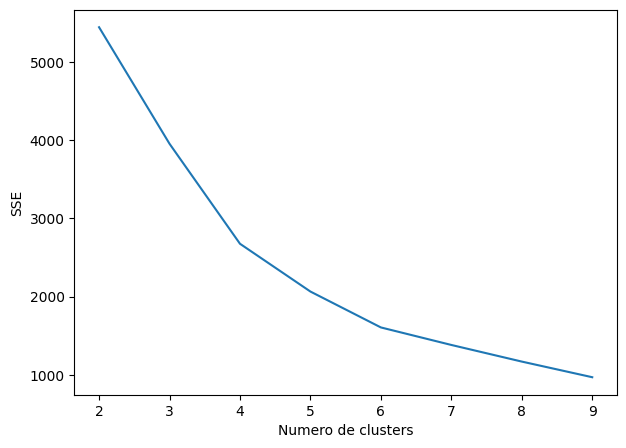

In [30]:
plt.figure(figsize=(7,5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Numero de clusters")
plt.ylabel("SSE")
plt.show()

Metodo del codo:

Parece ser que un valor optimo para este caso es 4

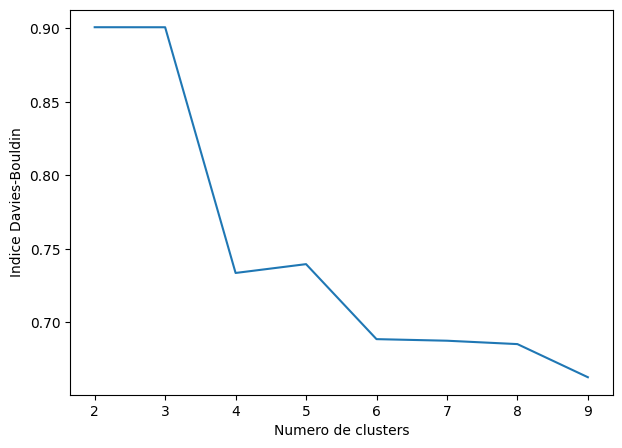

In [31]:
plt.figure(figsize=(7,5))
plt.plot(list(db.keys()), list(db.values()))
plt.xlabel("Numero de clusters")
plt.ylabel("Indice Davies-Bouldin")
plt.show()

Davies-Bouldin Index
Cluster = 9

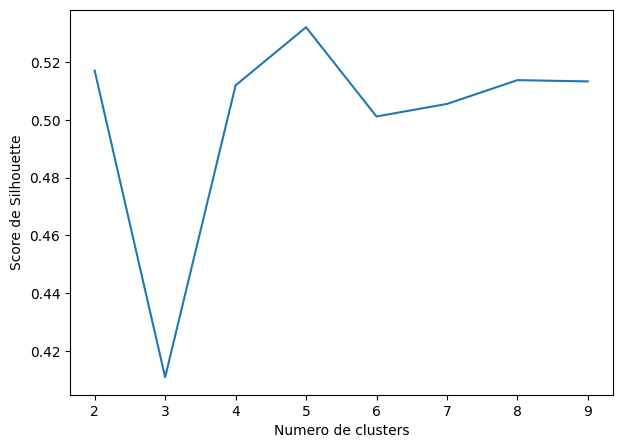

In [32]:
plt.figure(figsize=(7,5))
plt.plot(list(slc.keys()), list(slc.values()))
plt.xlabel("Numero de clusters")
plt.ylabel("Score de Silhouette")
plt.show()

Indice de Silhouette

Cluster = 5

Para n_clusters = 2 El promedio del score de silhouette es:  0.5169993351338104
Para n_clusters = 3 El promedio del score de silhouette es:  0.41091596795635843
Para n_clusters = 4 El promedio del score de silhouette es:  0.5119228867221521
Para n_clusters = 5 El promedio del score de silhouette es:  0.532034325302656
Para n_clusters = 6 El promedio del score de silhouette es:  0.501145859743609
Para n_clusters = 7 El promedio del score de silhouette es:  0.5054862538105308
Para n_clusters = 8 El promedio del score de silhouette es:  0.5137229820037184
Para n_clusters = 9 El promedio del score de silhouette es:  0.5132883762433609


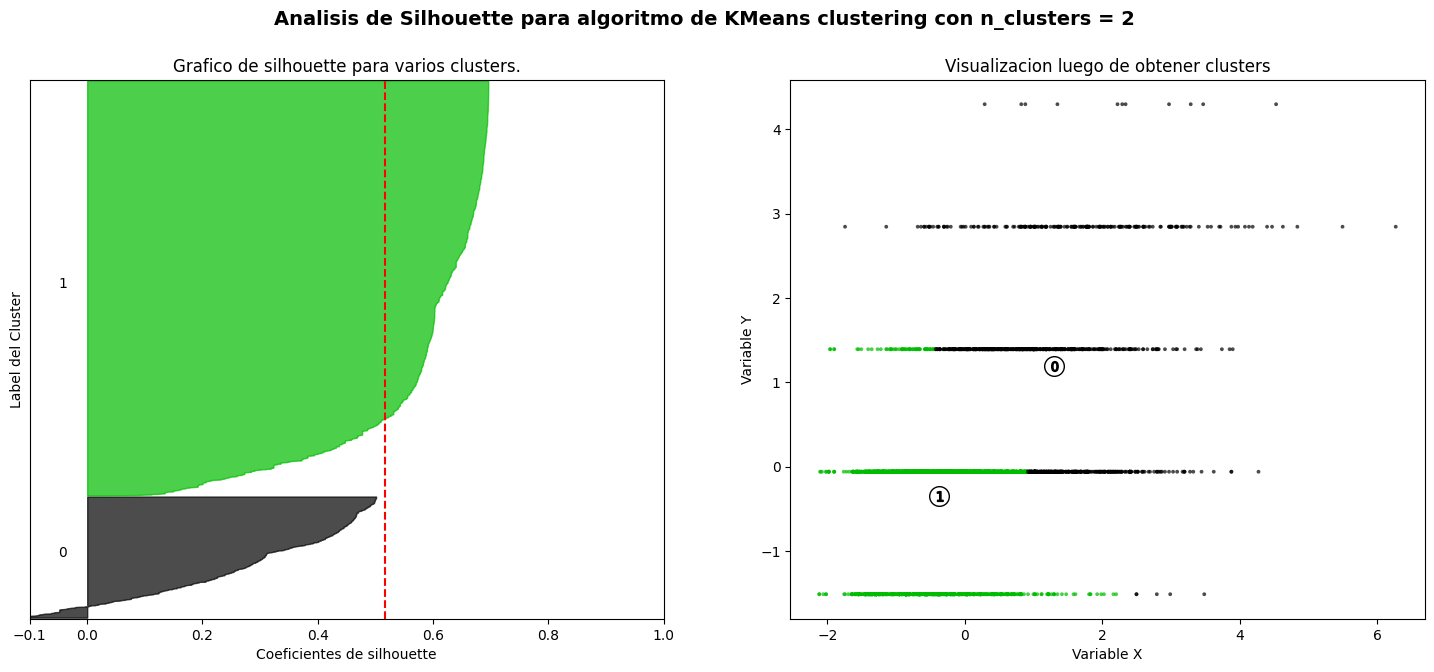

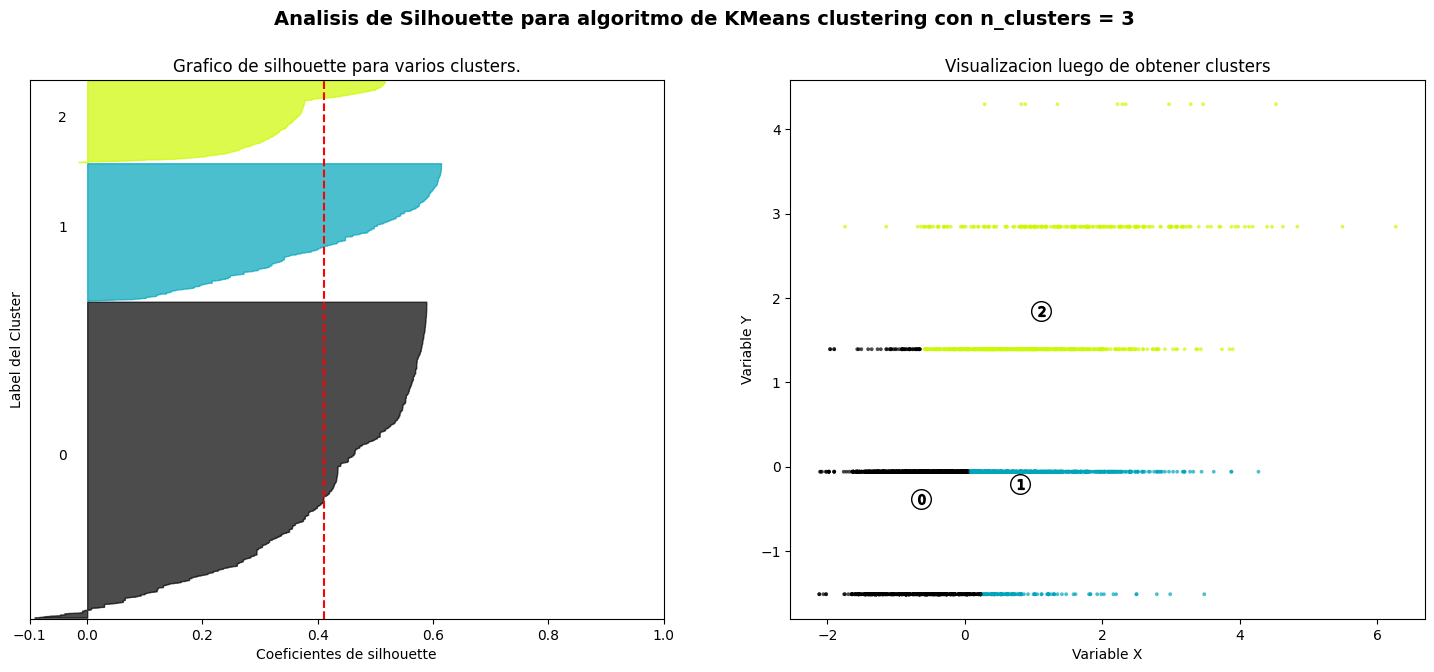

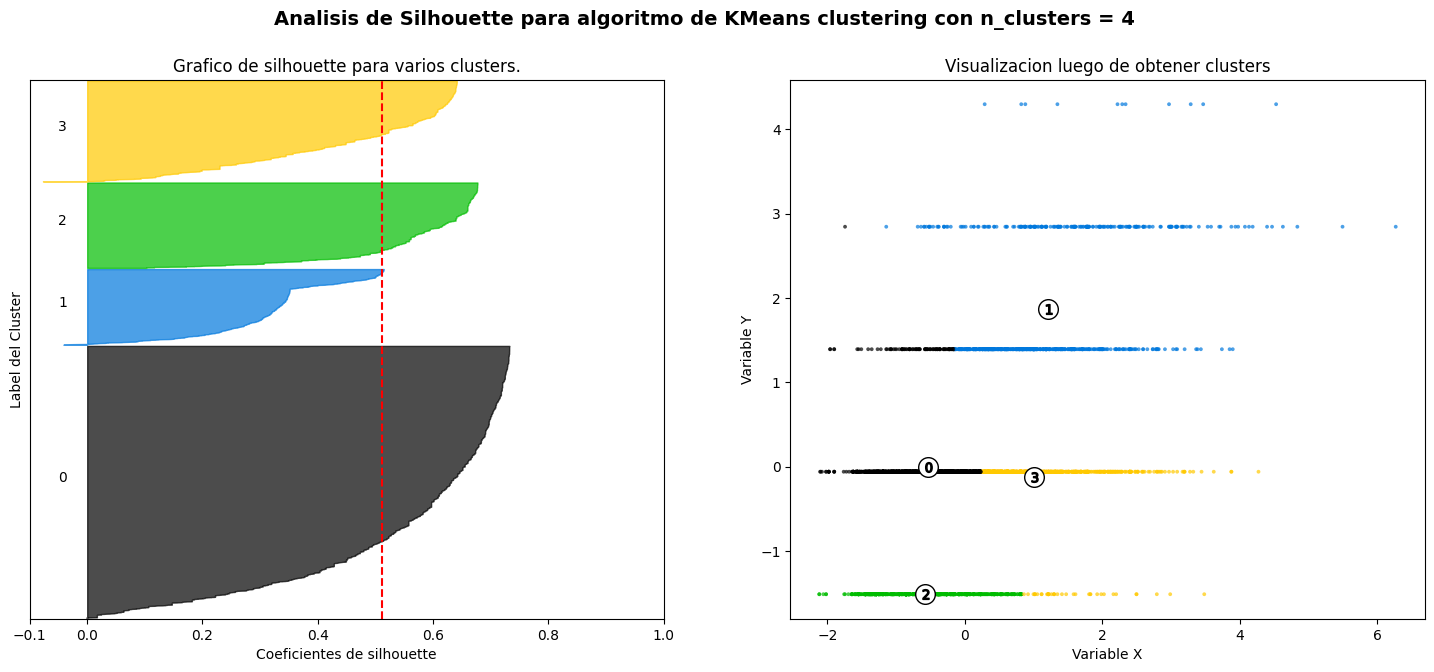

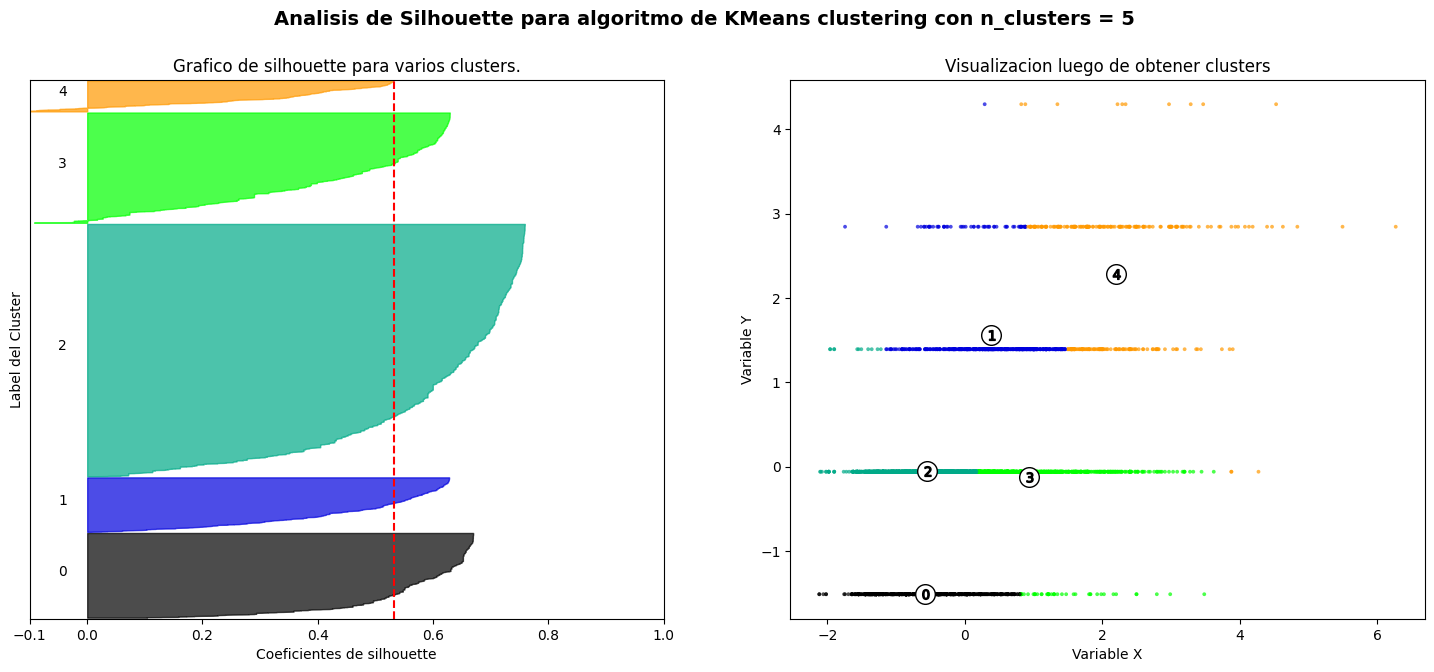

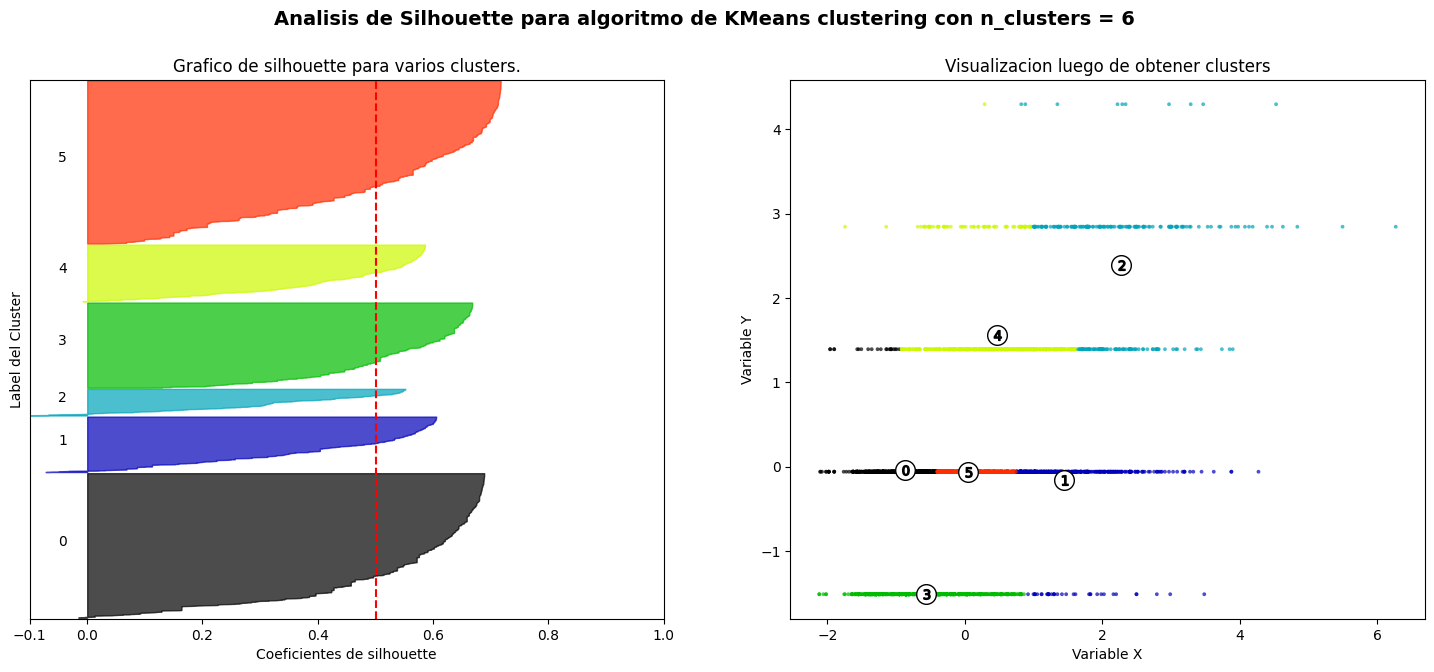

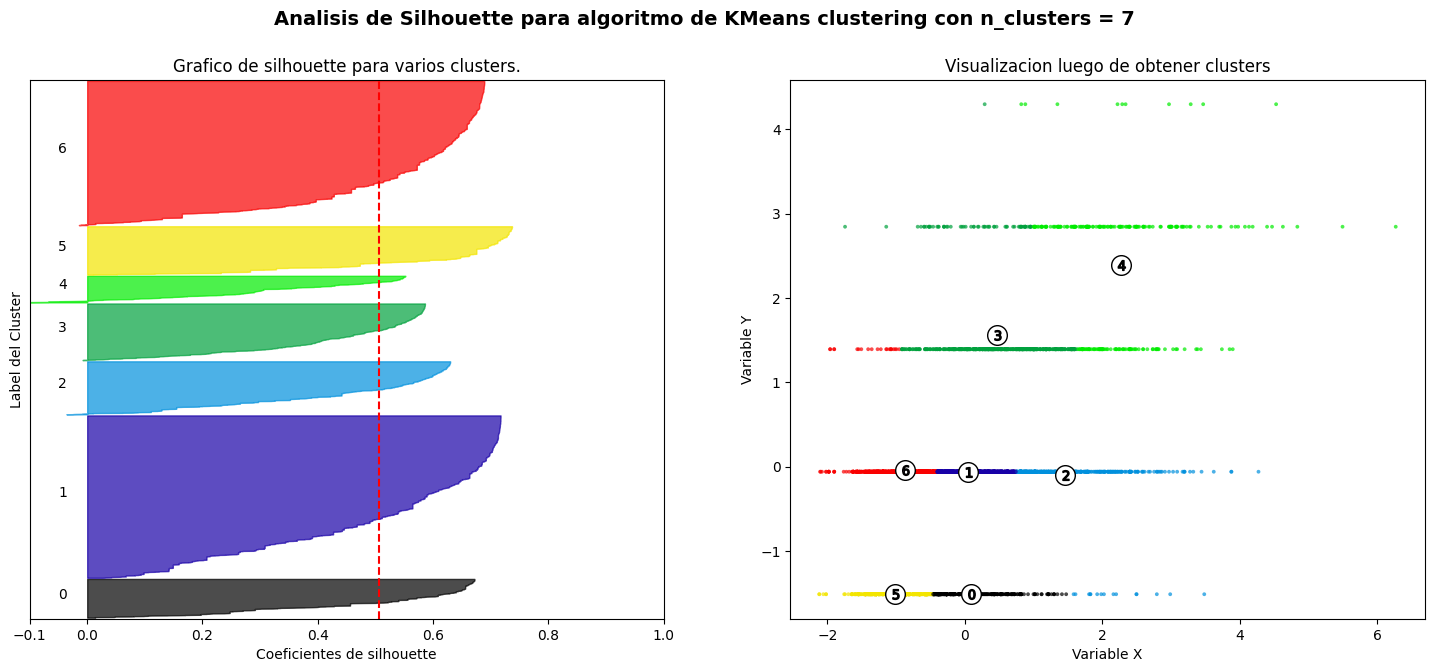

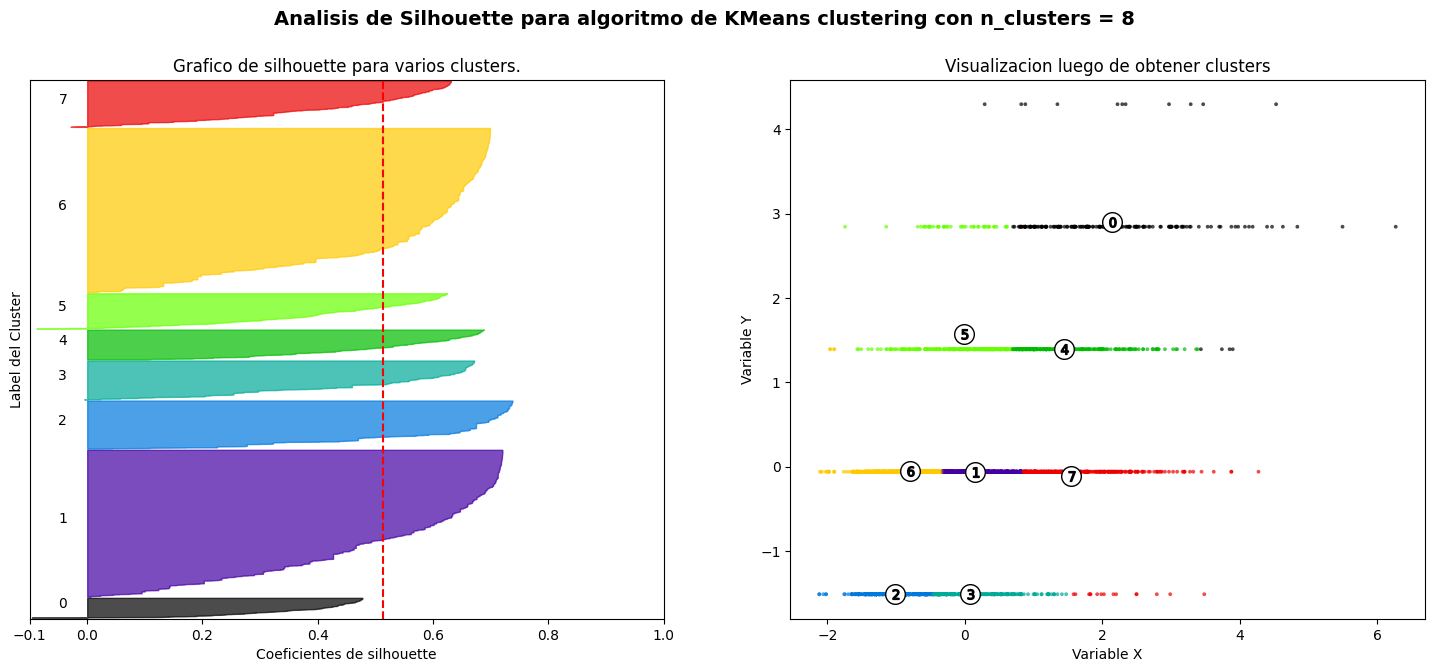

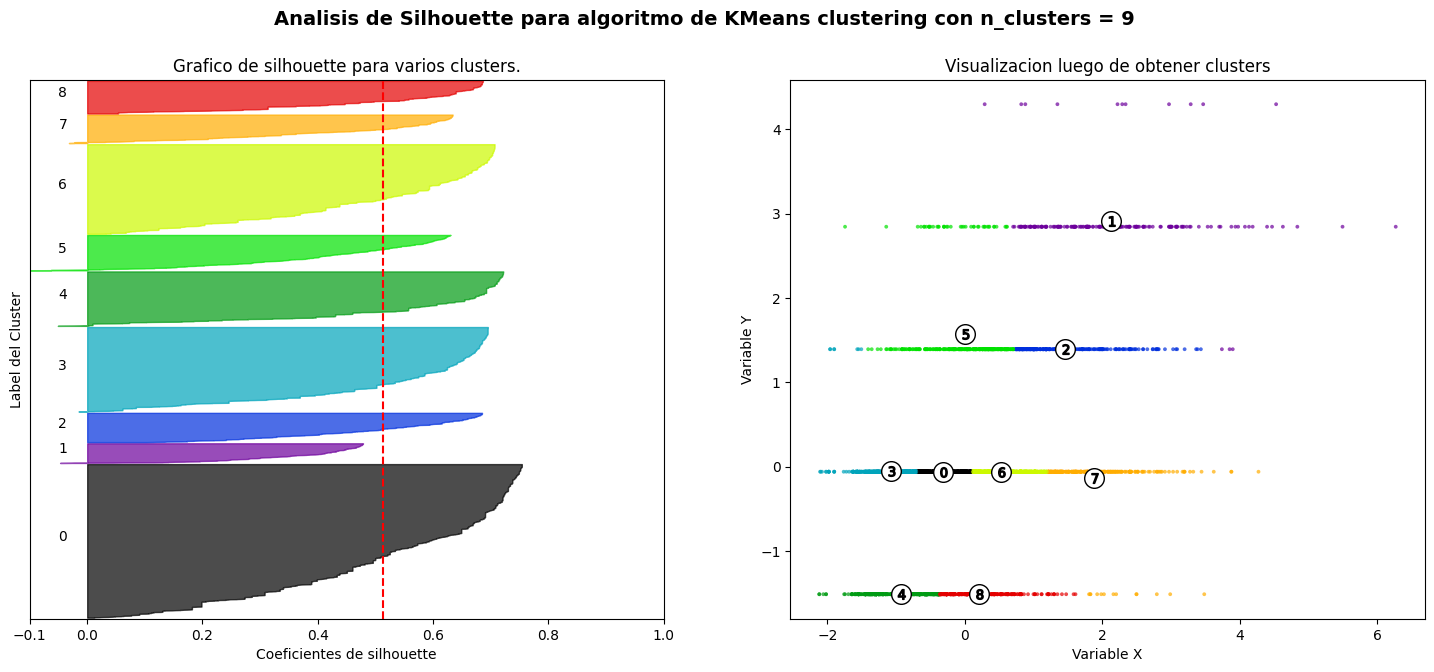

In [33]:
for n_clusters in range(2, 10):
    # Crear un subplot de 1 fila y 2 columnas
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # El 1 subplot es para el score de silhouette
    # El rango del Ind. silhouette es [-1, 1]
    ax1.set_xlim([-0.1, 1]) # para nuestro caso lo voy a dejar en este rango
    # El (n_clusters+1)*10 es para insertar un espacio en blanco entre la silueta
     # y el grafico de la nube de puntos
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # Iniciamos el proceso de ajuste a los datos
    clusterer = KMeans(n_clusters=n_clusters,max_iter=1000, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    # El score de silhouette_score da el promedio de todos los valores
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El promedio del score de silhouette es: ", silhouette_avg)
    # Calcular el score de silhouette para cada muestra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregar los scores de silhouette para las muestras pertenecientes al cluster i y ordenarlos
        ith_cluster_silhouette_values =sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort() # Ordenar
        size_cluster_i = ith_cluster_silhouette_values.shape[0] # Tamaño de clusters
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters) # Definir paleta de colores
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Etiquetar las graficas de silhouette con sus miembros de cluster en el medio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcular el nuevo y_lower para la proxima grafica
        y_lower = y_upper + 10
    ax1.set_title("Grafico de silhouette para varios clusters.")
    ax1.set_xlabel("Coeficientes de silhouette")
    ax1.set_ylabel("Label del Cluster")
    # La linea vertical para el promedio del score de silhouette de todos los valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Quitar labels en y
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]) # definir ticks para comparacion

    # 2 grafica mostrando los clusters formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters) # definir colores
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k') # scatterplot
    # Etiquetar a los clusters
    centers = clusterer.cluster_centers_
    # Dibujar en color blanco los centroides de los clusters
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')
    # Enumerar los centroides
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

    ax2.set_title("Visualizacion luego de obtener clusters")
    ax2.set_xlabel("Variable X")
    ax2.set_ylabel("Variable Y")

    plt.suptitle(("Analisis de Silhouette para algoritmo de KMeans clustering "
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

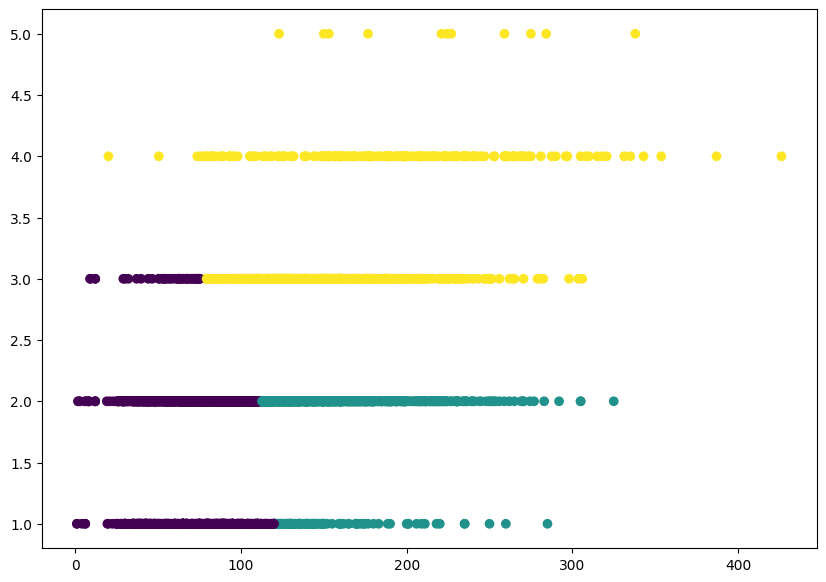

In [34]:
# desnormalizar los datos
X = sc.inverse_transform(X)
plt.figure(figsize=(10,7))
plt.scatter(X[:,0],X[:,1], c = labels)
plt.show()

PRUEBA 2

---


---




---



In [35]:
df_reservas

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,deposit_type_le,market_segment_le,reserved_room_type_le,assigned_room_type_le,customer_type_le,mes_arribo_numero,total_pasajeros,total_estadia,grupo_pasajeros,es_grupo_familiar
41055,0,185,2016,41,2,3,5,3,0,0,...,0,5,0,3,2,10,3,8,4,0
1830,0,50,2016,14,31,0,3,2,0,0,...,0,4,0,0,3,3,2,3,5,0
34455,1,61,2017,21,21,2,1,2,0,0,...,0,6,0,0,2,5,2,3,5,0
33648,0,41,2015,46,8,2,3,2,0,0,...,0,5,3,3,1,11,2,5,5,0
78527,0,0,2016,4,20,0,4,1,0,0,...,0,3,0,0,2,1,1,4,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82364,1,0,2015,37,9,0,1,2,0,0,...,0,3,0,0,2,9,2,1,5,0
73793,0,0,2017,7,16,0,1,1,0,0,...,0,2,0,0,2,2,1,1,6,0
5808,0,10,2015,38,17,0,1,2,0,0,...,0,6,0,4,0,9,2,1,5,0
62894,1,101,2016,31,25,1,1,2,0,0,...,0,6,0,0,2,7,2,2,5,0


Mean Squared Error: 0.00025679999999999995


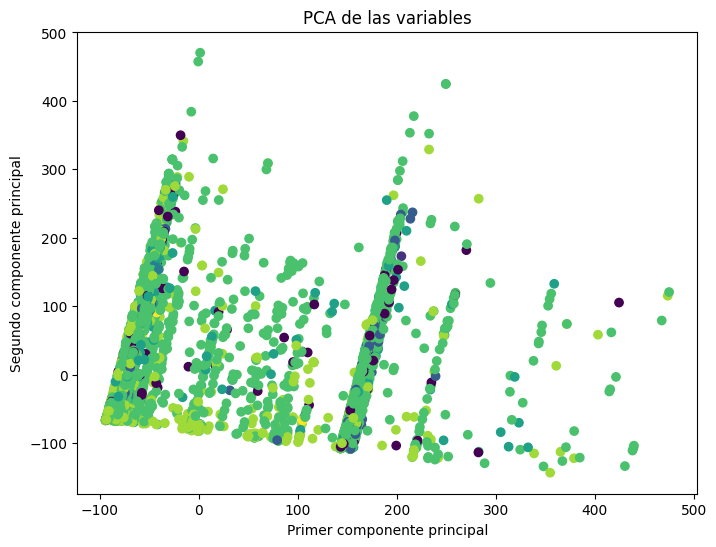

Cargas de variables en PC1 y PC2:
     is_canceled  lead_time  arrival_date_year  arrival_date_week_number  \
PC1     0.000109   0.172171           0.000122                  0.007268   
PC2     0.001001   0.984590           0.001258                  0.015595   

     arrival_date_day_of_month  stays_in_weekend_nights  stays_in_week_nights  \
PC1                   0.002203                 0.002016              0.004894   
PC2                   0.001751                 0.002551              0.006640   

       adults  children    babies  ...  distribution_channel_le  \
PC1  0.000256  0.000148  0.000073  ...                 0.001267   
PC2  0.000801  0.000250  0.000007  ...                 0.001716   

     deposit_type_le  market_segment_le  reserved_room_type_le  \
PC1         0.000001           0.001455               0.003253   
PC2         0.000195           0.001752              -0.000073   

     assigned_room_type_le  customer_type_le  mes_arribo_numero  \
PC1               0.00331

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Dejamos únicamente las características númericas
df_features = df_reservas.select_dtypes(include='number')

# Dividir datos en conjuntos de entrenamiento y prueba
X = df_features.drop('grupo_pasajeros', axis=1)  # Features
y = df_features['grupo_pasajeros']  # Variable objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Evaluar modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Selección de variables
feature_importances = model.feature_importances_
important_features = X.columns[feature_importances > 0.01]

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualizar las cargas de los dos primeros componentes
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Primer componente principal')
plt.ylabel('Segundo componente principal')
plt.title('PCA de las variables')
plt.show()

# Obtener las cargas de las variables en los dos primeros componentes
loadings = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2'])
print('Cargas de variables en PC1 y PC2:')
print(loadings)


es el logo de ENRON?

OTRA PRUEBA Y ERROR


---



---


---



In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [38]:
analizar_dataframe(df_reservas,0)

,Tipo de dato,Total No nulos,Total nulos,Porcentaje Nulos,Borrar,Columna con Espacios,count,mean,std,min,25%,50%,75%,max
is_canceled,int64,5000,0,0.000000,,False,5000.000000,0.280000,0.450000,0.000000,0.000000,0.000000,1.000000,1.000000
lead_time,int64,5000,0,0.000000,,False,5000.000000,79.940000,85.210000,0.000000,12.000000,48.000000,127.000000,545.000000
arrival_date_year,int64,5000,0,0.000000,,False,5000.000000,2016.200000,0.690000,2015.000000,2016.000000,2016.000000,2017.000000,2017.000000
arrival_date_week_number,int64,5000,0,0.000000,,False,5000.000000,27.020000,13.630000,1.000000,16.000000,28.000000,37.000000,53.000000
arrival_date_day_of_month,int64,5000,0,0.000000,,False,5000.000000,15.610000,8.850000,1.000000,8.000000,16.000000,23.000000,31.000000
stays_in_weekend_nights,int64,5000,0,0.000000,,False,5000.000000,1.020000,1.050000,0.000000,0.000000,1.000000,2.000000,16.000000
stays_in_week_nights,int64,5000,0,0.000000,,False,5000.000000,2.690000,2.090000,0.000000,1.000000,2.000000,4.000000,40.000000
adults,int64,5000,0,0.000000,,False,5000.000000,1.900000,0.490000,0.000000,2.000000,2.000000,2.000000,4.000000
children,int64,5000,0,0.000000,,False,5000.000000,0.140000,0.450000,0.000000,0.000000,0.000000,0.000000,3.000000
babies,int64,5000,0,0.000000,,False,5000.000000,0.010000,0.110000,0.000000,0.000000,0.000000,0.000000,2.000000


In [39]:
# Dividir los datos en características (X) y etiquetas (y)
X = df_reservas.drop(columns=['total_pasajeros'])
y = df_reservas['total_pasajeros']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir un pipeline con preprocesamiento (escalado) y modelo (Random Forest)
pipeline = Pipeline([
    ('scaler', StandardScaler()),       # Escalado de características
    ('pca', PCA()),                     # PCA para reducción de dimensionalidad
    ('clf', RandomForestClassifier())   # Modelo de clasificación (Random Forest)
])

# Definir los parámetros a buscar en la búsqueda de hiperparámetros
param_grid = {
    'pca__n_components': [5, 10, 15],       # Número de componentes principales a mantener
    'clf__n_estimators': [50, 100, 200],    # Número de árboles en el bosque aleatorio
    'clf__max_depth': [5]                   # Profundidad máxima de cada árbol en el bosque
}

In [40]:
# Realizar una búsqueda de hiperparámetros utilizando validación cruzada en el conjunto de entrenamiento
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo encontrado por la búsqueda de hiperparámetros
best_model = grid_search.best_estimator_

# Realizar predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

In [41]:
# Imprimir el informe de clasificación
print(classification_report(y_test, y_pred))

# Explorar las cargas de los dos primeros componentes principales
pca = best_model.named_steps['pca']
first_component_loadings = pca.components_[0]
second_component_loadings = pca.components_[1]

              precision    recall  f1-score   support

           1       0.99      0.67      0.80       171
           2       0.87      1.00      0.93       657
           3       0.84      0.62      0.72       109
           4       0.86      0.70      0.77        61
           5       0.00      0.00      0.00         2

    accuracy                           0.88      1000
   macro avg       0.71      0.60      0.64      1000
weighted avg       0.89      0.88      0.87      1000



In [42]:
# Identificar las variables más relevantes utilizando las cargas de los componentes principales
feature_names = X.columns
most_relevant_features_first_component = feature_names[abs(first_component_loadings).argsort()[::-1][:3]]
most_relevant_features_second_component = feature_names[abs(second_component_loadings).argsort()[::-1][:3]]

# Imprimir las variables más relevantes en los dos primeros componentes principales
print("Variables más relevantes en el primer componente principal:", most_relevant_features_first_component)
print("Variables más relevantes en el segundo componente principal:", most_relevant_features_second_component)

Variables más relevantes en el primer componente principal: Index(['grupo_pasajeros', 'es_grupo_familiar', 'reserved_room_type_le'], dtype='object')
Variables más relevantes en el segundo componente principal: Index(['total_estadia', 'es_grupo_familiar', 'children'], dtype='object')
